## Source
https://langchain-ai.github.io/langgraph/tutorials/introduction/

## Levels of automation
<div style="text-align:center">
    <img src="./images/LevelsOfAutomation.png" alt="levels of automation" width='80%'>
</div>

### Install the required packages

In [ ]:
%pip install -U langgraph langsmith langchain_openai langchain_community

### Set environment variables

In [11]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

OPENAI_API_KEY = os.getenv("COGITO_OPENAI_API_KEY")

### 1. The State of the graph

In [4]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

### 2. Nodes for the graph

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name="gpt-4o-mini",
)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}

### 3. The workflow of the graph

In [7]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

graph = workflow.compile()


### Lets take a look at our graph

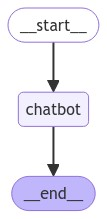

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the graph

In [14]:
while True:
    user_input = input("User: ")
    print("User: " + user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Hva heter sjefen i OpenAI?
Assistant: Per oktober 2021 var Sam Altman CEO i OpenAI. For den mest oppdaterte informasjonen anbefales det å sjekke OpenAIs offisielle nettsider eller nyhetskilder, ettersom ledelsen kan ha endret seg siden den gang.
User: q
Goodbye!


### 4. Lets add tools to the graph

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]


In [33]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: GraphState):
    """
    Simple bot that invokes the list of previous messages
    and returns the result which will be added to the list of messages.
    """
    return {"messages": [llm.invoke(state["messages"])]}

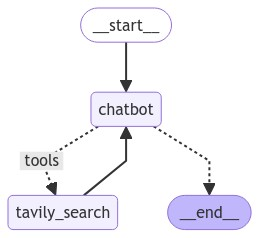

In [34]:
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(GraphState)

# Adding nodes to the workflow
workflow.add_node("chatbot", chatbot)
workflow.add_node("tavily_search", ToolNode(tools))

# Defining edges between nodes
workflow.add_edge(START, "chatbot")
workflow.add_edge("tavily_search", "chatbot")

# Defining conditional edges
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tavily_search",
        END: END,
    }
)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: Trondheim er en livlig by med mange aktiviteter og arrangementer som skjer gjennom året. Her er noen ting du kan sjekke ut:

1. **Kulturarrangementer**: Trondheim har et variert kulturliv med konserter, teaterforestillinger og kunstutstillinger. Sjekk ut programmet til Rockheim, Trondheim Kunstmuseum eller Samfundet for aktuelle hendelser.

2. **Mat og drikke**: Byen har et spennende utvalg av restauranter og kafeer. Det kan være verdt å sjekke ut de lokale matmarkedene eller spesialrestauranter som serverer tradisjonell norsk mat.

3. **Utendørsaktiviteter**: Trondheim ligger nær vakker natur, med muligheter for turer, sykling og andre friluftsaktiviteter. Bymarka er et populært område for både turer og ski om vinteren.

4. **Historiske steder**: Besøk Nidarosdomen, den imponerende katedralen, eller Bakklandet, det sjarmerende gamle bydelen med trehus og koselige kafeer.

5. **Festivaler**: Trondheim arrangerer flere festivaler gjennom året, som for eksempel Trondheim Jazzf